# Autoencoder No Supervisado con MNIST

Este notebook implementa un autoencoder usando PyTorch para el dataset MNIST.

**Nota:** Debido a que la GPU RTX 5060 Ti (arquitectura Blackwell) aún no está soportada por PyTorch, el entrenamiento se realizará en CPU.

## 1. Importar Librerías

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Configurar dispositivo (CPU por compatibilidad con RTX 5060 Ti)
device = torch.device('cpu')
print(f'🖥️ Dispositivo: {device}')
print('⚠️ Entrenando en CPU debido a GPU no soportada (~8-10 min)\n')

🖥️ Dispositivo: cpu
⚠️ Entrenando en CPU debido a GPU no soportada (~8-10 min)



## 2. Configurar Hiperparámetros

In [29]:
# Hiperparámetros
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 32  # Dimensión del espacio latente

## 3. Cargar Dataset MNIST

In [30]:
# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'✅ Imágenes de entrenamiento: {len(train_dataset)}')
print(f'✅ Imágenes de prueba: {len(test_dataset)}')

✅ Imágenes de entrenamiento: 60000
✅ Imágenes de prueba: 10000


## 4. Definir Arquitectura del Autoencoder

In [31]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder, self).__init__()
        
        # Encoder: 784 → latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder: latent_dim → 784
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.view(reconstructed.size(0), 1, 28, 28)
        return reconstructed, latent

# Crear modelo
model = Autoencoder(latent_dim=latent_dim).to(device)
print(model)
print(f'\n📊 Parámetros totales: {sum(p.numel() for p in model.parameters()):,}')

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)

📊 Parámetros totales: 1,141,296


## 5. Configurar Pérdida y Optimizador

In [32]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print('✅ Optimizador y función de pérdida configurados')

✅ Optimizador y función de pérdida configurados


## 6. Entrenar el Autoencoder

In [33]:
train_losses = []
test_losses = []

print('🚀 Iniciando entrenamiento...\n')

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        
        # Forward
        reconstructed, _ = model(images)
        loss = criterion(reconstructed, images)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluación
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch [{epoch+1:2d}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}')

print('\n✅ Entrenamiento completado!')

🚀 Iniciando entrenamiento...

Epoch [ 1/20] - Train Loss: 0.1845 | Test Loss: 0.1096
Epoch [ 2/20] - Train Loss: 0.0939 | Test Loss: 0.0806
Epoch [ 3/20] - Train Loss: 0.0742 | Test Loss: 0.0667
Epoch [ 4/20] - Train Loss: 0.0625 | Test Loss: 0.0578
Epoch [ 5/20] - Train Loss: 0.0537 | Test Loss: 0.0496
Epoch [ 6/20] - Train Loss: 0.0474 | Test Loss: 0.0448
Epoch [ 7/20] - Train Loss: 0.0429 | Test Loss: 0.0411
Epoch [ 8/20] - Train Loss: 0.0400 | Test Loss: 0.0387
Epoch [ 9/20] - Train Loss: 0.0375 | Test Loss: 0.0379
Epoch [10/20] - Train Loss: 0.0359 | Test Loss: 0.0357
Epoch [11/20] - Train Loss: 0.0343 | Test Loss: 0.0343
Epoch [12/20] - Train Loss: 0.0332 | Test Loss: 0.0337
Epoch [13/20] - Train Loss: 0.0319 | Test Loss: 0.0328
Epoch [14/20] - Train Loss: 0.0310 | Test Loss: 0.0315
Epoch [15/20] - Train Loss: 0.0300 | Test Loss: 0.0308
Epoch [16/20] - Train Loss: 0.0291 | Test Loss: 0.0294
Epoch [17/20] - Train Loss: 0.0284 | Test Loss: 0.0294
Epoch [18/20] - Train Loss: 0.0277 

## 7. Visualizar Curvas de Pérdida

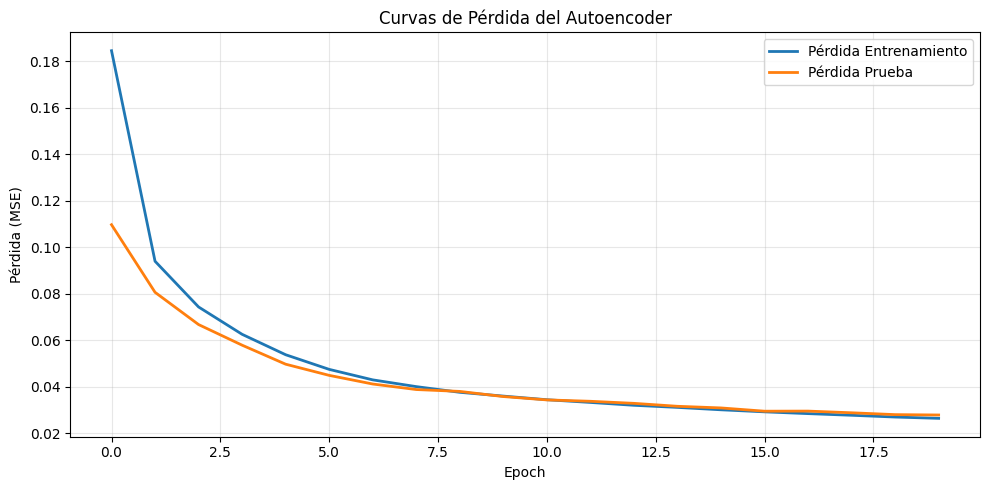

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida Entrenamiento', linewidth=2)
plt.plot(test_losses, label='Pérdida Prueba', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de Pérdida del Autoencoder')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Visualizar Reconstrucciones

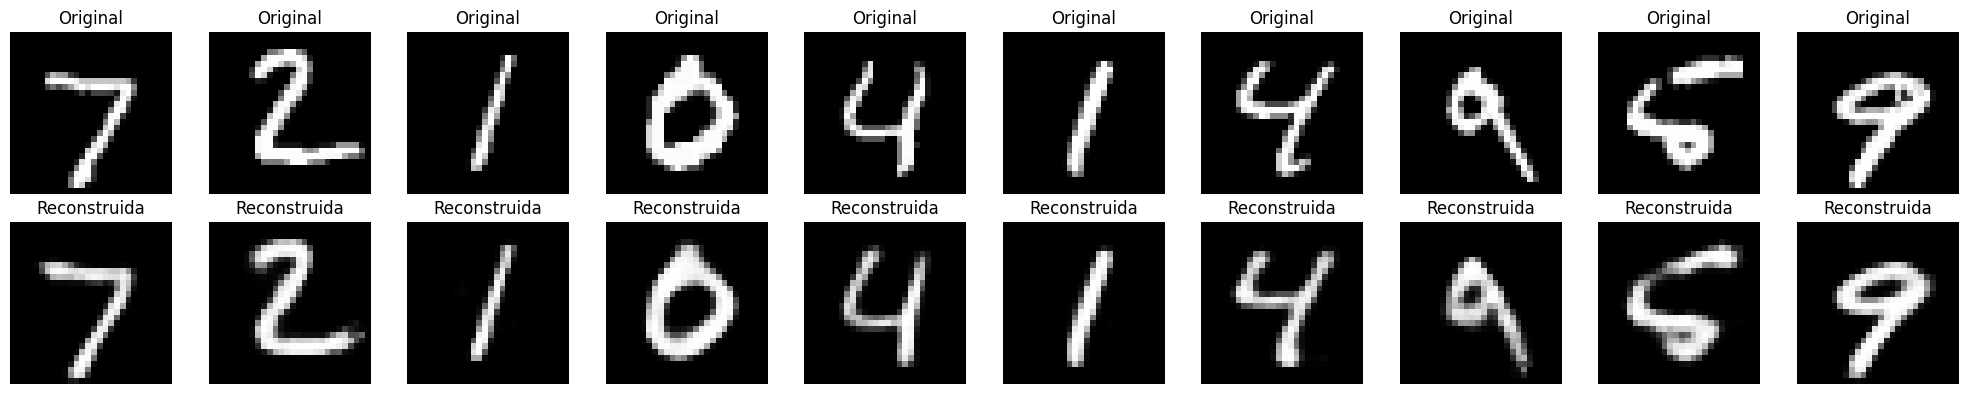

In [35]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    reconstructed, _ = model(images)
    
    images = images.cpu()
    reconstructed = reconstructed.cpu()

# Mostrar 10 ejemplos
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    # Reconstruidas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title('Reconstruida')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 9. Visualizar Espacio Latente con t-SNE

Aplicando t-SNE (puede tardar 1-2 min)...


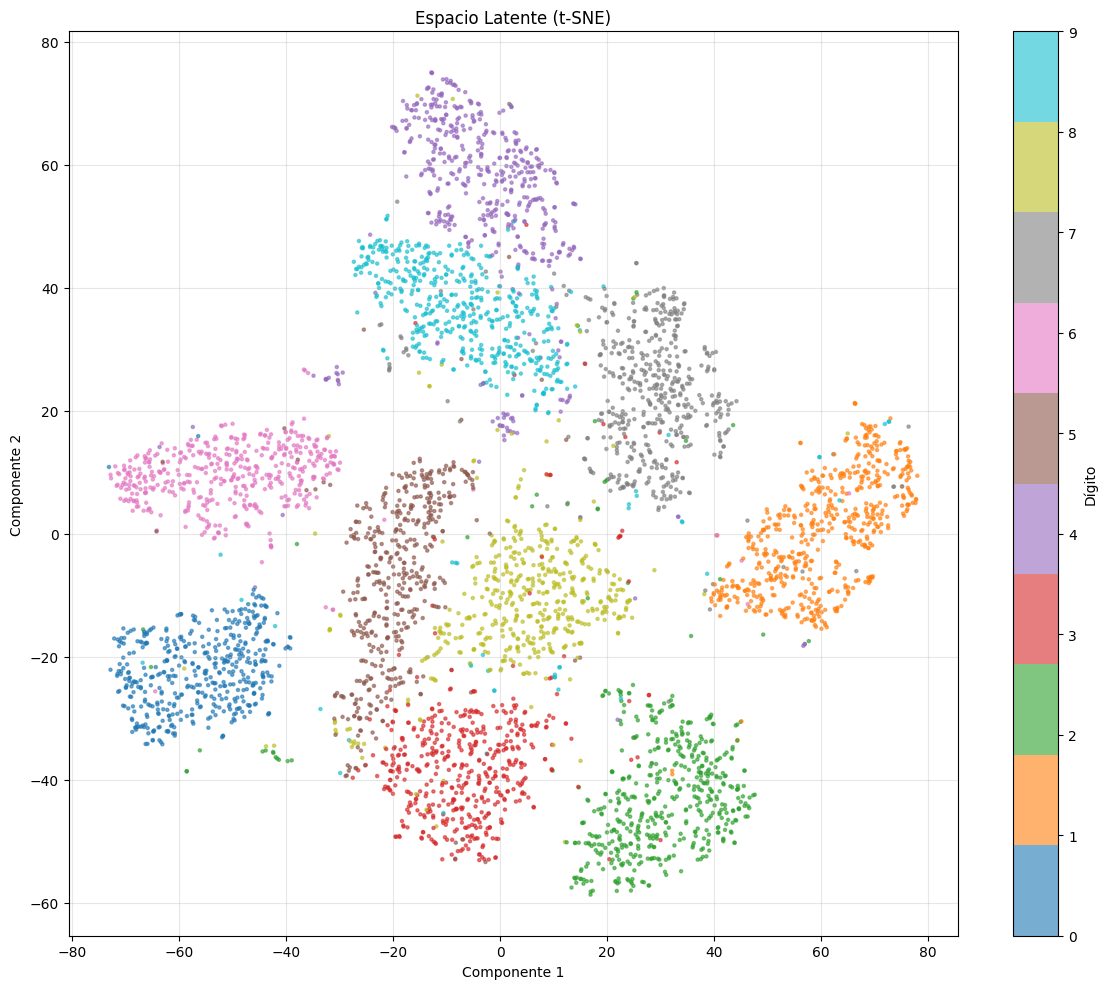

In [36]:
from sklearn.manifold import TSNE

# Extraer representaciones latentes
latent_vectors = []
labels = []

model.eval()
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        _, latent = model(images)
        latent_vectors.append(latent.cpu().numpy())
        labels.append(lbls.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# t-SNE
print('Aplicando t-SNE (puede tardar 1-2 min)...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_vectors[:5000])

# Visualizar
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                     c=labels[:5000], cmap='tab10', 
                     alpha=0.6, s=5)
plt.colorbar(scatter, label='Dígito')
plt.title('Espacio Latente (t-SNE)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Guardar Modelo

In [37]:
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
}, 'mnist_autoencoder.pth')

print('✅ Modelo guardado: mnist_autoencoder.pth')

✅ Modelo guardado: mnist_autoencoder.pth
